In [ ]:
# como siempre antes que nada importamos todo
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Vuelvo a arrancar, ahora directo con Fashion MNIST para el trabajo 3, probablemente el trabajo 4 tambien sea un autoencoder para seguir con lo mismo, de esa forma hay tiempo para este trabajo.

In [ ]:
transform = transforms.ToTensor()
# introducimos los datasets
train_dataset = torchvision.datasets.FashionMNIST(root = "./data" , train = True , download = True ,  transform = transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data" , train = False , download = True ,  transform = transform)

In [ ]:
#declaramos el dataloader y elegimos el batch
batch = 32
dataloader = torch.utils.data.DataLoader(train_dataset , batch_size = batch)
test_dataloader = torch.utils.data.DataLoader(test_dataset , batch_size = batch)

In [ ]:
#Ahora podemos definir nuestra red neuronal
capa_interna = 2

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Sequential(
        nn.Dropout(0.1),
        nn.Linear(28*28, 512),
        nn.Dropout(0.1),
        nn.Linear(512, 256),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.Dropout(0.1),
        nn.Linear(64, 32),
        nn.Dropout(0.1),
        nn.Linear(32, 16),
        nn.Dropout(0.1),
        nn.Linear(16, 8),
        nn.Dropout(0.1),
        nn.Linear(8, 4),
        nn.Dropout(0.1),
        nn.Linear(4, capa_interna),
        )
    self.fc2 = nn.ReLU()
    self.DO = nn.Dropout(0.1)

  def forward(self, x):

    x = self.fc1(x)
    x = self.fc2(x)
    return x


class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Sequential(
        nn.Dropout(0.1),
        nn.Linear(capa_interna, 4),
        nn.Dropout(0.1),
        nn.Linear(4, 8),
        nn.Dropout(0.1),
        nn.Linear(8, 16),
        nn.Dropout(0.1),
        nn.Linear(16, 32),
        nn.Dropout(0.1),
        nn.Linear(32, 64),
        nn.Dropout(0.1),
        nn.Linear(64, 128),
        nn.Dropout(0.1),
        nn.Linear(128, 256),
        nn.Dropout(0.1),
        nn.Linear(256, 512),
        nn.Dropout(0.1),
        nn.Linear(512, 28*28)
        )
    self.fc2 = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    return x


In [ ]:
#elegimos dispositivo, no me queda claro si esto es necesario o no
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# y mandamos los moodelos al dispositivo
Enc = Encoder().to(device)
Dec = Decoder().to(device)


In [ ]:
# elegimos funcion de error y optimizador
loss_fn = nn.MSELoss()
optimizer_Enc = torch.optim.Adam(Enc.parameters(), lr = 0.001)
optimizer_Dec = torch.optim.Adam(Dec.parameters(), lr = 0.001)

In [ ]:
train_loss = []
test_loss = []

In [ ]:
numero_epocas = 50

In [ ]:
num_batches_test = 10000/batch
num_batches_train = 60000/batch

i = 1
for epoch in range(numero_epocas):
  print(f'Epoch:{i}')
  i = i+1
  train_epoch_loss = 0
  for (imgs , _) in dataloader:
    imgs = imgs.to(device)
    #100 , 1 , 28 , 28 ---> (100 , 28*28)
    imgs = imgs.flatten(1)
    latents = Enc(imgs)
    output = Dec(latents)

    loss = loss_fn(output , imgs)
    train_epoch_loss += loss.cpu().detach().numpy()

    optimizer_Enc.zero_grad()
    optimizer_Dec.zero_grad()

    loss.backward()

    optimizer_Enc.step()
    optimizer_Dec.step()

  train_loss.append(train_epoch_loss/num_batches_train)

  test_epoch_loss = 0
  for (imgs , _) in test_dataloader:
    imgs = imgs.to(device)
    #100 , 1 , 28 , 28 ---> (100 , 28*28)
    imgs = imgs.flatten(1)

    t_loss = loss_fn(Dec(Enc(imgs)),imgs)

    test_epoch_loss += t_loss.cpu().detach().numpy()
  test_loss.append(test_epoch_loss/num_batches_test)

Epoch:1
Epoch:2
Epoch:3
Epoch:4
Epoch:5
Epoch:6
Epoch:7
Epoch:8
Epoch:9
Epoch:10
Epoch:11
Epoch:12
Epoch:13
Epoch:14
Epoch:15
Epoch:16
Epoch:17
Epoch:18
Epoch:19
Epoch:20
Epoch:21
Epoch:22
Epoch:23
Epoch:24
Epoch:25
Epoch:26
Epoch:27
Epoch:28
Epoch:29
Epoch:30
Epoch:31
Epoch:32
Epoch:33
Epoch:34
Epoch:35
Epoch:36
Epoch:37
Epoch:38
Epoch:39
Epoch:40
Epoch:41
Epoch:42
Epoch:43
Epoch:44
Epoch:45
Epoch:46
Epoch:47
Epoch:48
Epoch:49
Epoch:50


In [ ]:
# Guardemos el modelo asi no tenemos que volver a correrlo
torch.save(Encoder, f"Encoder_{capa_interna}.pth")
torch.save(Decoder, f"Decoder_{capa_interna}.pth")

In [ ]:
#model = CNN().to(device)
#model.load_state_dict(torch.load("model.pth"))

Text(0.5, 0, 'Epoca')

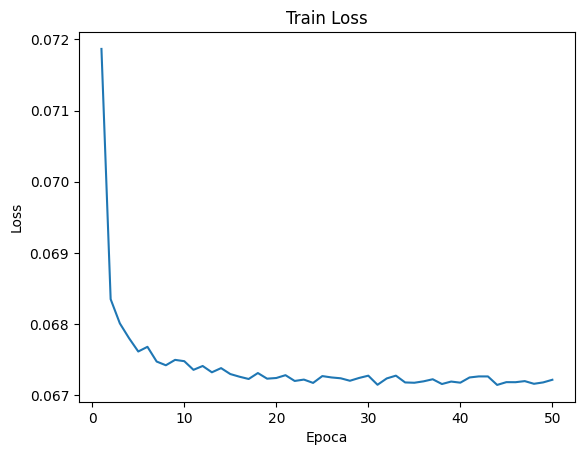

In [ ]:
x = np.arange(1,numero_epocas+1)
plt.plot(x,train_loss)
plt.title("Train Loss")
plt.ylabel("Loss")
plt.xlabel("Epoca")

Text(0.5, 0, 'Epoca')

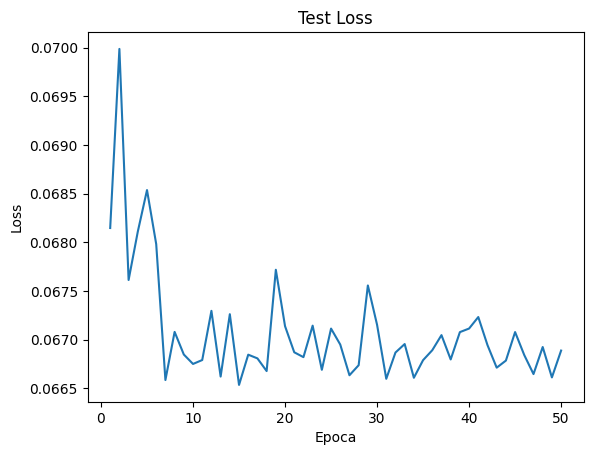

In [ ]:
x = np.arange(1,numero_epocas+1)
plt.plot(x,test_loss)
plt.title("Test Loss")
plt.ylabel("Loss")
plt.xlabel("Epoca")

In [ ]:
#guardamos el array
np.savetxt(f'train_loss_{capa_interna}.csv', train_loss)
np.savetxt(f'test_loss_{capa_interna}.csv', test_loss)

Ahora con los errores ya calculados puedo hacer los gráficos aca cargando los datos

In [ ]:
Test_64 = np.loadtxt('test_loss_64.csv')
Test_128 = np.loadtxt('test_loss_128.csv')
Test_256 = np.loadtxt('test_loss_256.csv')
Test_512 = np.loadtxt('test_loss_512.csv')

FileNotFoundError: ignored

In [ ]:
Train_64 = np.loadtxt('train_loss_64.csv')
Train_128 = np.loadtxt('train_loss_128.csv')
Train_256 = np.loadtxt('train_loss_256.csv')
Train_512 = np.loadtxt('train_loss_512.csv')

In [ ]:
x = np.arange(1,numero_epocas+1)

plt.plot(x,Test_64, label='Test 64',linestyle='-', c='red')
plt.plot(x,Train_64, label='Train 64', linestyle='--', c='red')
plt.plot(x,Test_128, label='Test 128', linestyle='-', c='blue')
plt.plot(x,Train_128, label='Train 128', linestyle='--', c='blue')
plt.plot(x,Test_256, label='Test 256', linestyle='-', c='green')
plt.plot(x,Train_256, label='Train 256', linestyle='--', c='green')
plt.plot(x,Test_512, label='Test 512', linestyle='-', c='black')
plt.plot(x,Train_512, label='Train 512', linestyle='--', c='black')
plt.plot(plotsize=(12, 6))

plt.title("Comparación de todas las redes")
plt.ylabel("Loss")
plt.xlabel("Epoca")
plt.legend()
plt.savefig("Grafico_todos_Errores.png", dpi =300)
plt.show()

In [ ]:
default_figsize = plt.rcParams["figure.figsize"]
print("Tamaño por defecto:", default_figsize)

In [ ]:
#x = np.arange(1,numero_epocas+1)
#plt.plot(x,Train_64, label='Capa 64')
#plt.plot(x,Train_128, label='Capa 128')
#plt.plot(x,Train_256, label='Capa 256')
#plt.plot(x,Train_512, label='Capa 512')
#plt.title("Train Loss")
#plt.ylabel("Loss")
#plt.xlabel("Epoca")
#plt.legend()
#plt.savefig("Grafico Errores Entrenamiento.png", dpi =300)
#plt.show()

In [ ]:
x = np.arange(1,numero_epocas+1)
plt.plot(x,Train_64, label='Train', linestyle='-', c='red')
plt.plot(x,Test_64, label='Test', linestyle='-.', c='black')
plt.title("Errores en 50 epocas para 64 neuronas")
plt.ylabel("Loss")
plt.xlabel("Epoca")
plt.legend()
plt.savefig(f"Grafico_ambos_errores_{capa_interna}.png", dpi =300)
plt.show()

In [ ]:
# Cargamos el modelo del cual queremos crear las imagenes:
#Enc = Encoder().to(device)
#Dec = Decoder().to(device)
#Enc = (torch.load("Encoder_512.pth"))
#Dec = (torch.load("Decoder_512.pth"))
#Enc = Encoder().to(device)
#Dec = Decoder().to(device)

#Encoder, f"Encoder_{capa_interna}.pth"

In [ ]:
# Miramos que imagenes predice el modelo sin entrenar
# 4.b)
figure = plt.figure()
rows,cols = 3,2
i = 0 # subplot index
for row in range(1,rows+1):
    j = torch.randint(len(train_dataset),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    # Ploteamos la imagen original
    i += 1
    image,flatten_imagen = train_dataset[j]
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("original")
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
    # Ploteamos la imagen predicha
    i += 1
    figure.add_subplot(rows,cols,i)
    if row==1:
      plt.title("predicha")
    plt.axis("off")
    #image_pred = model.imagen(image)
    #Acá mando la imagen al dispositivo en el cual estoy trabajando.
    # le mandamos un flatten
    image = image.flatten(1)
    image_gpu = image.to(device)
    pred_gpu = Dec(Enc(image_gpu))
    pred_cpu = pred_gpu.detach().cpu().numpy().reshape((1,28,28)).squeeze()
    plt.imshow(pred_cpu,cmap="Greys_r")
#plt.show()
plt.savefig(f'Comparativa_{capa_interna}_neuronas')